# Analysis and visualization of M&M blind taste test data

Formal write up shared in Towards Data Science availabe [here](https://towardsdatascience.com/do-european-m-ms-actually-taste-better-than-american-m-ms-248e747a4c44).

Guiding questions:
1. Is there a global consensus that European M&M’s are in fact better than American M&M’s? 
1. Can Europeans actually detect a difference between M&M’s purchased in the US vs in Europe when they don’t know which one they are eating? Or is this a grand, coordinated lie amongst Europeans to make Americans feel embarrassed? 
1. Are Americans actually taste-blind to American vs European M&M’s? Or can they taste a difference but simply don’t describe this difference as “an improvement” in flavor?
1. Can these alleged taste differences be perceived by citizens of other continents? If so, do they find one flavor obviously superior?

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import chi2_contingency
import statsmodels.stats.power as smp

# plotting
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns

## Load participant data

In [2]:
participants = pd.read_csv('data/participants.txt',sep='\t')
participants.head()

,participant_id,continent_of_origin
0,1,North America
1,2,Europe
2,3,North America
3,4,Europe
4,5,Europe


In [3]:
# mapping of participant id to continent
p2c = dict(participants.values)

In [4]:
# separate counts by those collected in Denmark vs US
participants['data_collection'] = participants['participant_id'].apply(
    lambda x: "collected in Lyngby" if x <=14 else "collected in Seattle")

# for later analysis, combine Aus/South America into 1 group
participants['continent_adj'] = participants['continent_of_origin'].apply(lambda x: 'Aus/SA' if x in ['Australia','South America'] else x)

participants.head()

,participant_id,continent_of_origin,data_collection,continent_adj
0,1,North America,collected in Lyngby,North America
1,2,Europe,collected in Lyngby,Europe
2,3,North America,collected in Lyngby,North America
3,4,Europe,collected in Lyngby,Europe
4,5,Europe,collected in Lyngby,Europe


### plot the distriubtion of particpants across continents


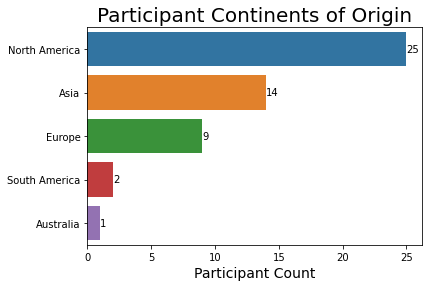

In [5]:
# seaborn plot
con_counts = participants['continent_of_origin'].value_counts()

ax = sns.barplot(y=con_counts.keys(),x=con_counts.values)
ax.bar_label(ax.containers[0])
plt.xlabel("Participant Count", fontsize=14)
plt.title("Participant Continents of Origin",fontsize=20)
plt.show()

In [6]:
# altair grouped bar
alt.Chart(participants).mark_bar().encode(
    alt.Y("continent_of_origin:N"),
    alt.X("count(continent_of_origin)"),
    alt.Color("continent_of_origin:N"),
    alt.Row("data_collection:N"),
)

alt.Chart(...)

In [8]:
# altair stacked bar with text
bars = alt.Chart(participants).mark_bar().encode(
    x=alt.X('count(continent_of_origin)',
            title="Count of participants ",
            axis=alt.Axis(titleFontSize=12)),
    y=alt.Y('continent_of_origin',title="",sort='-x',axis=alt.Axis(labelFontSize=14)),
    color=alt.Color('data_collection:N',title="",
                    legend=alt.Legend(
                        orient='none',
                        legendX=180, legendY=115,
                        direction='vertical',
                        titleAnchor='middle',
                        strokeColor='black',
                        padding=2)
                   ).scale(scheme="tableau20"),    
    tooltip=['continent_of_origin','data_collection','count(continent_of_origin)']
).properties(width=300,height=150,title="Distribution of participant continent of origin")


text_indiv = alt.Chart(participants).mark_text(dx=1,align='left',size=12).encode(
     x=alt.X('count(continent_of_origin)').stack('zero'),
     y=alt.Y('continent_of_origin',title="",sort='-x',axis=alt.Axis(labelFontSize=14)),
    detail='data_collection:N',
    color='data_collection',
    text=alt.Text('count(continent_of_origin):Q')
)

chart = bars + text_indiv
chart.save('figs/participant_sampling.html')
chart.save('json/fig1_participant_sampling.json')
chart

alt.LayerChart(...)

## Load M&M id data

In [9]:
# load M&M id data
mnms = pd.read_csv('data/mnm.txt',sep='\t')
mnms.head()

,mnm_id,origin
0,1,USA
1,2,Denmark


In [10]:
# mapping of mnm id to origin
m2o = dict(mnms.values)
m2o

{1: 'USA', 2: 'Denmark'}

## Load taste response data

In [11]:
df = pd.read_csv('data/taste_data.txt',sep='\t').fillna("")
df.head()

,participant_id,mnm_id,mnm_color,taste_response,notes
0,1,2,green,normal,
1,1,1,orange,bad,
2,1,1,blue,normal,
3,1,2,brown,normal,
4,1,1,yellow,bad,


In [12]:
# add continent and mnm ID column to taste data
df['continent'] = df['participant_id'].apply(lambda x: p2c[x])
df['continent_adj'] = df['continent'].apply(lambda x: 'Aus/SA' if x in ['Australia','South America'] else x)
df['mnm_origin'] = df['mnm_id'].apply(lambda x: m2o[x])
df.head()

,participant_id,mnm_id,mnm_color,taste_response,notes,continent,continent_adj,mnm_origin
0,1,2,green,normal,,North America,North America,Denmark
1,1,1,orange,bad,,North America,North America,USA
2,1,1,blue,normal,,North America,North America,USA
3,1,2,brown,normal,,North America,North America,Denmark
4,1,1,yellow,bad,,North America,North America,USA


# Results 3.1
## Overall population response to “USA M&Ms” vs “Denmark M&Ms”
For now, we disregard participant continent of origin and look at the collective taste response of all participants to M&Ms sourced from the US vs Europe.

In [13]:
taste_order = ['bad','normal','good']

chart = alt.Chart(df).mark_bar(size=90).encode(
    x=alt.X('mnm_origin:N',title="M&M origin",
            axis=alt.Axis(labelAngle=0,labelFontSize=14,titleFontSize=14),sort='descending'),
    y=alt.Y('count(taste_response)',title="Percent of Responses",
            axis=alt.Axis(labelFontSize=14,titleFontSize=14)).stack('normalize'),
    color=alt.Color('taste_response:N',sort=taste_order,title="Taste",
                    legend=alt.Legend(labelFontSize=14,titleFontSize=16)
                   ).scale(scheme='brownbluegreen'),
    order=alt.Order('color_taste_response_sort_index:Q',sort='descending'),
    tooltip=['taste_response','count(taste_response)']
).properties(width=210)

chart.save('json/fig2_overall_qual.json')
chart

alt.Chart(...)

Overall, more participants reported European-sourced M&M's as tasting "good," but also as tasting "bad". USA-sourced M&M's were more commonly reported to taste "normal" than either "good" or "bad."

### Prepare contingency table for X2 tests on difference between categorical reponse distributions
Calculate the taste response counts of each response for each continent to each M&M type

In [14]:
table_count = df.groupby(['mnm_origin','continent_adj'])['taste_response'].value_counts()
table_perc = df.groupby(['mnm_origin','continent_adj'])['taste_response'].value_counts(normalize=True)
cont_table = pd.concat([table_count,table_perc], axis=1, keys=['count', 'percentage'])
cont_table

count  percentage
mnm_origin continent_adj taste_response                   
Denmark    Asia          good               27    0.385714
                         bad                24    0.342857
                         normal             19    0.271429
           Aus/SA        normal             11    0.733333
                         bad                 4    0.266667
           Europe        normal             17    0.377778
                         good               16    0.355556
                         bad                12    0.266667
           North America good               57    0.456000
                         normal             37    0.296000
                         bad                31    0.248000
USA        Asia          normal             30    0.428571
                         good               21    0.300000
                         bad                19    0.271429
           Aus/SA        normal             10    0.666667
                         good                3    0.200000
                         bad                 2    0.133333
           Europe        bad                22    0.488889
                         normal             15    0.333333
                         good                8    0.177778
           North America normal             60    0.480000
                         good               48    0.384000
                         bad                17    0.136000

Flatten index structure for easier use in pandas:

In [15]:
#table.reset_index()
cont_table2 = pd.DataFrame()
cont_table2['mnm_origin'] = cont_table.index.get_level_values(0)
cont_table2['continent_adj'] = cont_table.index.get_level_values(1)
cont_table2['taste_response'] = cont_table.index.get_level_values(2)
cont_table2['count'] = cont_table['count'].values
cont_table2['percentage'] = cont_table['percentage'].values
cont_table2

,mnm_origin,continent_adj,taste_response,count,percentage
0,Denmark,Asia,good,27,0.385714
1,Denmark,Asia,bad,24,0.342857
2,Denmark,Asia,normal,19,0.271429
3,Denmark,Aus/SA,normal,11,0.733333
4,Denmark,Aus/SA,bad,4,0.266667
5,Denmark,Europe,normal,17,0.377778
6,Denmark,Europe,good,16,0.355556
7,Denmark,Europe,bad,12,0.266667
8,Denmark,North America,good,57,0.456000
9,Denmark,North America,normal,37,0.296000


### Chi-squared test for taste response differences between two M&M types

In [75]:
# Chi squared test on all participant data
m1_m2_all_data_cont_table = cont_table2.groupby(['mnm_origin','taste_response']
                                 )['count'].aggregate('sum').unstack()
display(m1_m2_all_data_cont_table)
print(m1_m2_all_data_cont_table.values)

# Run X2 test
stat, p, dof, expected = chi2_contingency(m1_m2_all_data_cont_table.values)

print(f"stat: {stat} | p: {p} | degfree: {dof}")
print("expectation table:")
display(expected)

# interpret p-value
compare_string = f"\n* RESULT *\nComparing all participants on their evaluation of M&M's from USA vs Denmark, we find them statistically "
alpha = 0.05
if p <= alpha:
    print(compare_string + f'Dependent (reject H0, {p:.3E} <= {alpha})')
else:
    print(compare_string + f'Independent (H0 holds true, {p:.3f} > {alpha})')

print("\n___________________________")

taste_response,bad,good,normal
mnm_origin,,,
Denmark,71,100,84
USA,60,80,115


[[ 71 100  84]
 [ 60  80 115]]
stat: 7.9750320730028434 | p: 0.01854572385402023 | degfree: 2
expectation table:


array([[65.5, 90. , 99.5],
       [65.5, 90. , 99.5]])


* RESULT *
Comparing all participants on their evaluation of M&M's from USA vs Denmark, we find them statistically Dependent (reject H0, 1.855E-02 <= 0.05)

___________________________


### Convert categorical taste response to quantitative distribution to better understand participants' relative preference 
1. Assign a quantitative score to each taste response
1. Calculate sum/average/stdev
1. Calculate the difference/ratio between M&Ms for each participant

In [17]:
# taste_scale = { 
#     'bad':-1,
#     'normal':0,
#     'good':1,
# }

# decided to use positive integers to allow ratio calculations without 0s in the denominator
taste_scale = {
    'bad':1,
    'normal':2,
    'good':3,
}

#1. Assign quantitative score
df['taste_score'] = df['taste_response'].apply(lambda x: taste_scale[x])
df.head()

,participant_id,mnm_id,mnm_color,taste_response,notes,continent,continent_adj,mnm_origin,taste_score
0,1,2,green,normal,,North America,North America,Denmark,2
1,1,1,orange,bad,,North America,North America,USA,1
2,1,1,blue,normal,,North America,North America,USA,2
3,1,2,brown,normal,,North America,North America,Denmark,2
4,1,1,yellow,bad,,North America,North America,USA,1


In [18]:
# 2. Calculate taste score sum, average, and stdev for each participant
p_score_data = []

# group dataframe by individual participants
dfp = df.groupby('participant_id')

for p in dfp.groups:
    p_df = dfp.get_group(p)
    
    m1_vals = p_df[p_df['mnm_id']==1]['taste_score'].values
    m1_sum = sum(m1_vals)
    m1_ave = np.mean(m1_vals)
    m1_std = np.std(m1_vals)
    
    m2_vals = p_df[p_df['mnm_id']==2]['taste_score'].values
    m2_sum = sum(m2_vals)
    m2_ave = np.mean(m2_vals)
    m2_std = np.std(m2_vals)
    
    row = [p,m1_sum,m1_ave,m1_std,m2_sum,m2_ave,m2_std]
    p_score_data.append(row)

# collect calculated scores into df
p_score_df = pd.DataFrame(p_score_data, columns=[
    'participant_id',
    'm1_sum',
    'm1_ave',
    'm1_std',
    'm2_sum',
    'm2_ave',
    'm2_std'
])

# merge back with particpant id info
pdf = pd.merge(
    p_score_df,
    participants,
    how="inner",
    on='participant_id')

# set an ordering to later seaborn plots
pdf['continent_adj'] = pd.Categorical(pdf['continent_adj'], ['North America','Europe','Asia','Aus/SA'])

pdf.head()

,participant_id,m1_sum,m1_ave,m1_std,m2_sum,m2_ave,m2_std,continent_of_origin,data_collection,continent_adj
0,1,7,1.4,0.489898,9,1.8,0.748331,North America,collected in Lyngby,North America
1,2,5,1.0,0.000000,10,2.0,0.000000,Europe,collected in Lyngby,Europe
2,3,10,2.0,0.894427,10,2.0,0.894427,North America,collected in Lyngby,North America
3,4,9,1.8,0.400000,7,1.4,0.489898,Europe,collected in Lyngby,Europe
4,5,6,1.2,0.400000,11,2.2,0.748331,Europe,collected in Lyngby,Europe


In [19]:
# 3. Calculate taste score difference and ratio for each participant
pdf['mnm_diff'] = pdf.apply(lambda row: row['m1_sum'] - row['m2_sum'],axis=1)
pdf['mnm_ratio'] = pdf.apply(lambda row: np.log2(row['m1_ave']/row['m2_ave']),axis=1)

# Also average the stdev of responses to both M&M types - measure of consistency
pdf['ave_std'] = pdf.apply(lambda row: np.mean([row['m1_std'], row['m2_std']]),axis=1)

pdf.head()

,participant_id,m1_sum,m1_ave,m1_std,m2_sum,m2_ave,m2_std,continent_of_origin,data_collection,continent_adj,mnm_diff,mnm_ratio,ave_std
0,1,7,1.4,0.489898,9,1.8,0.748331,North America,collected in Lyngby,North America,-2,-0.362570,0.619115
1,2,5,1.0,0.000000,10,2.0,0.000000,Europe,collected in Lyngby,Europe,-5,-1.000000,0.000000
2,3,10,2.0,0.894427,10,2.0,0.894427,North America,collected in Lyngby,North America,0,0.000000,0.894427
3,4,9,1.8,0.400000,7,1.4,0.489898,Europe,collected in Lyngby,Europe,2,0.362570,0.444949
4,5,6,1.2,0.400000,11,2.2,0.748331,Europe,collected in Lyngby,Europe,-5,-0.874469,0.574166


### T-test of overall partipcipant average taste scores between two M&M types

The p-value for the Overall taste scores between M1 and M2:0.721


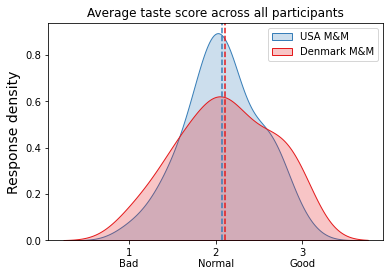

In [20]:
m1_aves = pdf['m1_ave'].values
m2_aves = pdf['m2_ave'].values

overall_m1_m2_pval = stats.ttest_ind(a=m1_aves, b=m2_aves, equal_var=True)[1]

print(f"The p-value for the Overall taste scores between M1 and M2:{overall_m1_m2_pval:.3f}")


# Figure
fig,ax = plt.subplots()
color_origin = sns.color_palette('Set1')

sns.kdeplot(x=m1_aves,fill=True,label='USA M&M',color=color_origin[1])
sns.kdeplot(x=m2_aves,fill=True,label='Denmark M&M',color=color_origin[0])

plt.axvline(np.mean(m1_aves),c=color_origin[1],linestyle='--')
plt.axvline(np.mean(m2_aves),c=color_origin[0],linestyle='--')

plt.xticks([1,2,3])
labels = ['1\nBad', '2\nNormal','3\nGood']
ax.set_xticklabels(labels)
plt.ylabel("Response density",fontsize=14)
plt.title("Average taste score across all participants")
plt.legend()
fig.savefig('figs/all_data_response_density.jpg',dpi=200)

# Results 3.2
## Continent specific responses to “USA M&Ms” vs “Denmark M&Ms”
Do participants from different continents percieve M&M's differently?

In [21]:
cont_perc = alt.Chart(df).mark_bar(size=40).encode(
    x=alt.X('mnm_origin:N',title="M&M origin",sort='descending',
            axis=alt.Axis(labelAngle=0,labelFontSize=10)),
    y=alt.Y('count(taste_response)',title="Percent of Responses",
            axis=alt.Axis(labelFontSize=14,titleFontSize=14)
           ).stack('normalize'),
    color=alt.Color('taste_response:N',sort=taste_order,
                    legend=alt.Legend(labelFontSize=14,titleFontSize=16),
                    title="Taste").scale(scheme='brownbluegreen'),
    order=alt.Order('color_taste_response_sort_index:Q',sort='descending'),
    column=alt.Column('continent_adj:N',title='',
                      header=alt.Header(labelFontSize=18),sort='descending'),
    tooltip=['continent_adj','taste_response','mnm_origin','count(taste_response)']
).properties(
    width=100,
    height=180
)

cont_perc

alt.Chart(...)

Almost 50% of the time a European participant evaluated a USA-sourced M&M, they reported it tasting "bad."

Almost 50% of the time a North American participant evaluated a Denmark-sourced M&M, they reported it tasting "good."

### Add a selectable legend to filter taste response group

In [22]:
selection = alt.selection_multi(fields=['taste_response'], bind='legend')

cont_count = alt.Chart(df).mark_bar(size=40).encode(
    x=alt.X('mnm_origin:N',title="M&M origin",sort = 'descending',
            axis=alt.Axis(labelAngle=0,labelFontSize=10)),
    y=alt.Y('count(taste_response)',title="Count of Responses",
            axis=alt.Axis(labelFontSize=14,titleFontSize=14)
           ),#.stack('normalize'),
    color=alt.Color('taste_response:N',sort=taste_order,title="Taste"
                   ).scale(scheme='brownbluegreen',
                           domain=taste_order),
    order=alt.Order('color_taste_response_sort_index:Q',sort='descending'),
    column=alt.Column('continent_adj:N',title='',
                      header=alt.Header(labelFontSize=18),sort='descending'),
    tooltip=['continent_adj','taste_response','mnm_origin','count(taste_response)']
).properties(
    width=100,
    height=180
).add_selection(
    selection
).transform_filter(
    selection
)
cont_count

/Users/erinwilson/miniconda3/envs/pytu_prac/lib/python3.11/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/Users/erinwilson/miniconda3/envs/pytu_prac/lib/python3.11/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)


alt.Chart(...)

Combine charts into one:

In [23]:
cont_comb = alt.vconcat(cont_count,cont_perc)
cont_comb.save('figs/continent_taste_response_interactive_legend.html')
cont_comb.save('json/fig4_continent_taste_response_interactive_legend.json')

cont_comb

alt.VConcatChart(...)

Reorganize bars to group by M&M type (filer out Aus/SA for clarity)

In [25]:
df_filt = df[df['continent_adj'] != 'Aus/SA']

cont_mnm_grouped = alt.Chart(df_filt).mark_bar(size=70).encode(
    x=alt.X('continent_adj:N',title="Participant continent",sort='descending',
            axis=alt.Axis(labelAngle=0,labelFontSize=14)),
    y=alt.Y('count(taste_response)',title="Percent of Responses",
            axis=alt.Axis(labelFontSize=14,titleFontSize=14)
           ).stack('normalize'),
    color=alt.Color('taste_response:N',sort=taste_order,
                    legend=alt.Legend(labelFontSize=14,titleFontSize=16),
                    title="Taste").scale(scheme='brownbluegreen'),
    order=alt.Order('color_taste_response_sort_index:Q',sort='descending'),
    column=alt.Column('mnm_origin:N',title='M&M Origin',
                      header=alt.Header(labelFontSize=18,titleFontSize=14),
                      sort='descending'),
    tooltip=['continent_adj','taste_response','mnm_origin','count(taste_response)']
).properties(width=240, height=200)

cont_mnm_grouped.save('json/fig5_continent_taste_response_grouped.json')
cont_mnm_grouped

alt.Chart(...)

### Show distribution of taste response counts of each continent

In [26]:
w = 60
h = 80
sp = 4

eu = alt.Chart(df[df['continent_adj']=='Europe'],).mark_bar(size=30).encode(
    alt.Y("count(taste_response):N",title="Count"),
    alt.X("mnm_origin",title='',sort=taste_order, # not sure why this sort is needed but it is
          axis=alt.Axis(labels=False)),
    alt.Color("mnm_origin:N",title='M&M Origin').scale(scheme="set1"),
    alt.Column("taste_response:N",sort=taste_order,spacing=sp,
               header=alt.Header(labelFontSize=14,title='Europe',titleFontSize=20)),
).properties(
    width=w,
    height=h,
)

na = alt.Chart(df[df['continent_adj']=='North America'],).mark_bar(size=30).encode(
    alt.Y("count(taste_response):N",title="Count"),
    alt.X("mnm_origin",title='',sort=taste_order, # not sure why this sort is needed but it is
          axis=alt.Axis(labels=False)),
    alt.Color("mnm_origin:N"),
    alt.Column("taste_response:N",sort=taste_order,spacing=sp,
               header=alt.Header(labelFontSize=14,title='North America',titleFontSize=20)),
).properties(
    width=w,
    height=h,
)

asi = alt.Chart(df[df['continent_adj']=='Asia'],).mark_bar(size=30).encode(
    alt.Y("count(taste_response):N",title="Count"),
    alt.X("mnm_origin",title='',sort=taste_order), # not sure why this sort is needed but it is
    alt.Color("mnm_origin:N"),
    alt.Column("taste_response:N",sort=taste_order,spacing=sp,
               header=alt.Header(labelFontSize=14,title='Asia',titleFontSize=20)),
).properties(
    width=w,
    height=h,
)

ausa = alt.Chart(df[df['continent_adj']=='Aus/SA'],).mark_bar(size=30).encode(
    alt.Y("count(taste_response):N",title="Count"),
    alt.X("mnm_origin",title=''), # not sure why this sort is NOT needed when the others are?
    alt.Color("mnm_origin:N"),
    alt.Column("taste_response:N",sort=taste_order,spacing=sp,
               header=alt.Header(labelFontSize=14,title='Aus/SA',titleFontSize=20)),
    order=alt.Order('column_taste_response_sort_index:Q')
).properties(
    width=w,
    height=h,
)

euna = alt.hconcat(eu,na)
aa = alt.hconcat(asi,ausa)
alt.vconcat(euna,aa
).configure_axis(
    grid=False,
)

alt.VConcatChart(...)

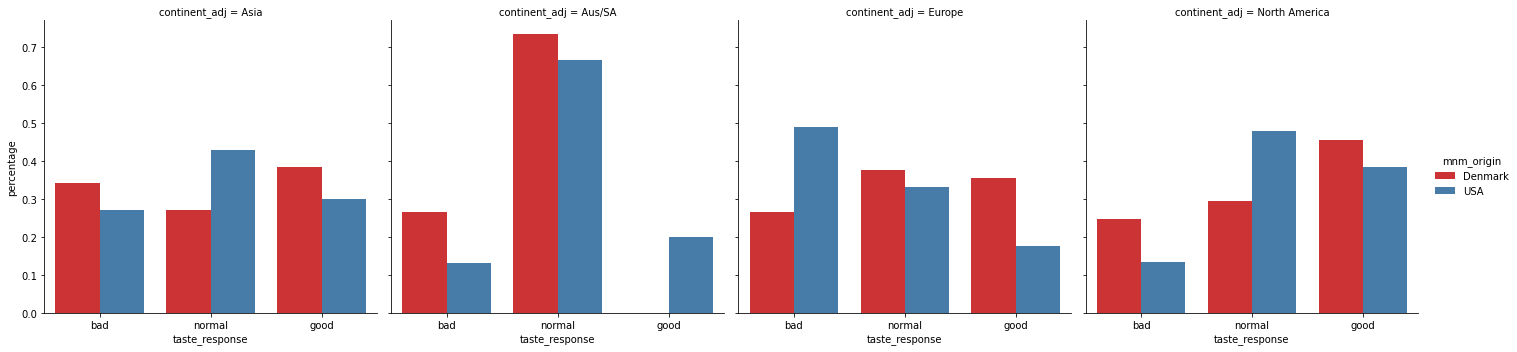

In [27]:
sns.catplot(data=cont_table2, x='taste_response',y='percentage',
            hue='mnm_origin',col="continent_adj",kind='bar',order=taste_order,palette='Set1')

### Chi-squared test for taste response differences between two continent responses to the *same* M&M

In [28]:
def chi_same_mnm_compare_continents(cont_table, mnm,groups):
    '''
    Perform a chi-squared analysis on two continent groups to 
    detect a difference in their feelings about a specific M&M origin
    
    For example: 
    Group A and B have a signifincantly different taste repsonse to M&M X.
    '''
    print("\n__________________________________________________________")
    print(f"Analyzing {groups} groups on M&M's from {mnm}")
    print("__________________________________________________________")
    
    sub_table = cont_table[(cont_table['mnm_origin']==mnm) & 
               (cont_table['continent_adj'].isin(groups))]

    # origin.groupby(['label', 'type'])['value'].aggregate('mean').unstack()
    # the aggregate doesn't do anything... can I remove and still use unstack?
    sub_table = sub_table.groupby(['continent_adj','taste_response']
                                 )['count'].aggregate('sum').unstack()
    display(sub_table)
    
    
    # Run x2 test
    stat, p, dof, expected = chi2_contingency(sub_table.values)
    
    print(f"stat: {stat} | p: {p} | degfree: {dof}")
    print("expectation table:")
    display(expected)

    # interpret p-value
    compare_string = f"\n* RESULT *\nComparing participants from {groups} on their evaluation of M&M's from {mnm}, we find them statistically "
    alpha = 0.05
    if p <= alpha:
        print(compare_string + f'Dependent (reject H0, {p:.3E} <= {alpha})')
    else:
        print(compare_string + f'Independent (H0 holds true, {p:.3f} > {alpha})')
        


#### Loop through pairs of continent groupings and compare their taste responses for a specific M&M

In [29]:
mnms = ['Denmark','USA']
groups = [
    ("Europe","North America"),
    ("Europe","Asia"),
    ("North America","Asia"),
]

for m in mnms:
    for (c1,c2) in groups:
        chi_same_mnm_compare_continents(cont_table2,m,[c1,c2])


__________________________________________________________
Analyzing ['Europe', 'North America'] groups on M&M's from Denmark
__________________________________________________________


taste_response,bad,good,normal
continent_adj,,,
Europe,12,16,17
North America,31,57,37


stat: 1.5196193907262532 | p: 0.46775543456848623 | degfree: 2
expectation table:


array([[11.38235294, 19.32352941, 14.29411765],
       [31.61764706, 53.67647059, 39.70588235]])


* RESULT *
Comparing participants from ['Europe', 'North America'] on their evaluation of M&M's from Denmark, we find them statistically Independent (H0 holds true, 0.468 > 0.05)

__________________________________________________________
Analyzing ['Europe', 'Asia'] groups on M&M's from Denmark
__________________________________________________________


taste_response,bad,good,normal
continent_adj,,,
Asia,24,27,19
Europe,12,16,17


stat: 1.5642047085845534 | p: 0.45744329180308263 | degfree: 2
expectation table:


array([[21.91304348, 26.17391304, 21.91304348],
       [14.08695652, 16.82608696, 14.08695652]])


* RESULT *
Comparing participants from ['Europe', 'Asia'] on their evaluation of M&M's from Denmark, we find them statistically Independent (H0 holds true, 0.457 > 0.05)

__________________________________________________________
Analyzing ['North America', 'Asia'] groups on M&M's from Denmark
__________________________________________________________


taste_response,bad,good,normal
continent_adj,,,
Asia,24,27,19
North America,31,57,37


stat: 2.0404090909090904 | p: 0.3605211896600571 | degfree: 2
expectation table:


array([[19.74358974, 30.15384615, 20.1025641 ],
       [35.25641026, 53.84615385, 35.8974359 ]])


* RESULT *
Comparing participants from ['North America', 'Asia'] on their evaluation of M&M's from Denmark, we find them statistically Independent (H0 holds true, 0.361 > 0.05)

__________________________________________________________
Analyzing ['Europe', 'North America'] groups on M&M's from USA
__________________________________________________________


taste_response,bad,good,normal
continent_adj,,,
Europe,22,8,15
North America,17,48,60


stat: 23.84621896621896 | p: 6.635281376879728e-06 | degfree: 2
expectation table:


array([[10.32352941, 14.82352941, 19.85294118],
       [28.67647059, 41.17647059, 55.14705882]])


* RESULT *
Comparing participants from ['Europe', 'North America'] on their evaluation of M&M's from USA, we find them statistically Dependent (reject H0, 6.635E-06 <= 0.05)

__________________________________________________________
Analyzing ['Europe', 'Asia'] groups on M&M's from USA
__________________________________________________________


taste_response,bad,good,normal
continent_adj,,,
Asia,19,21,30
Europe,22,8,15


stat: 5.890704473547197 | p: 0.052583534699244754 | degfree: 2
expectation table:


array([[24.95652174, 17.65217391, 27.39130435],
       [16.04347826, 11.34782609, 17.60869565]])


* RESULT *
Comparing participants from ['Europe', 'Asia'] on their evaluation of M&M's from USA, we find them statistically Independent (H0 holds true, 0.053 > 0.05)

__________________________________________________________
Analyzing ['North America', 'Asia'] groups on M&M's from USA
__________________________________________________________


taste_response,bad,good,normal
continent_adj,,,
Asia,19,21,30
North America,17,48,60


stat: 5.609782608695651 | p: 0.06051334835298294 | degfree: 2
expectation table:


array([[12.92307692, 24.76923077, 32.30769231],
       [23.07692308, 44.23076923, 57.69230769]])


* RESULT *
Comparing participants from ['North America', 'Asia'] on their evaluation of M&M's from USA, we find them statistically Independent (H0 holds true, 0.061 > 0.05)


### Chi-squared test for taste response differences between the two M&M for a given continent

In [30]:
def chi_same_continent_compare_mnm(cont_table, cont):
    '''
    Perform a chi-squared analysis on a given continent group to 
    detect a difference in their feelings about M&M's from different origins
    
    For example: 
    Group A has a signifincantly different taste repsonse to M&M X vs M&M Y.
    '''
    print("\n_______________________________________________")
    print(f"Analyzing {cont} on M&M's from Denmark vs USA")
    print("_______________________________________________")

    
    sub_table = cont_table[cont_table['continent_adj']==cont]

    # origin.groupby(['label', 'type'])['value'].aggregate('mean').unstack()
    # the aggregate doesn't do anything... can I remove and still use unstack?
    sub_table = sub_table.groupby(['mnm_origin','taste_response']
                                 )['count'].aggregate('sum').unstack()
    display(sub_table)
    print(sub_table.values)
    
    stat, p, dof, expected = chi2_contingency(sub_table.values)
    
    print(f"stat: {stat} | p: {p} | degfree: {dof}")
    print("expectation table:")
    display(expected)

    # interpret p-value
    compare_string = f"\n* RESULT *\nComparing participants from {cont} on their evaluation of M&M's from USA vs Denmark, we find them statistically "
    alpha = 0.05
    if p <= alpha:
        print(compare_string + f'Dependent (reject H0, {p:.3E} <= {alpha})')
    else:
        print(compare_string + f'Independent (H0 holds true, {p:.3f} > {alpha})')
    

In [31]:
for cont in ['Europe','North America','Asia']:
    chi_same_continent_compare_mnm(cont_table2,cont)


_______________________________________________
Analyzing Europe on M&M's from Denmark vs USA
_______________________________________________


taste_response,bad,good,normal
mnm_origin,,,
Denmark,12,16,17
USA,22,8,15


[[12 16 17]
 [22  8 15]]
stat: 5.732843137254902 | p: 0.056902183250639164 | degfree: 2
expectation table:


array([[17., 12., 16.],
       [17., 12., 16.]])


* RESULT *
Comparing participants from Europe on their evaluation of M&M's from USA vs Denmark, we find them statistically Independent (H0 holds true, 0.057 > 0.05)

_______________________________________________
Analyzing North America on M&M's from Denmark vs USA
_______________________________________________


taste_response,bad,good,normal
mnm_origin,,,
Denmark,31,57,37
USA,17,48,60


[[31 57 37]
 [17 48 60]]
stat: 10.308370152184587 | p: 0.00577518449388042 | degfree: 2
expectation table:


array([[24. , 52.5, 48.5],
       [24. , 52.5, 48.5]])


* RESULT *
Comparing participants from North America on their evaluation of M&M's from USA vs Denmark, we find them statistically Dependent (reject H0, 5.775E-03 <= 0.05)

_______________________________________________
Analyzing Asia on M&M's from Denmark vs USA
_______________________________________________


taste_response,bad,good,normal
mnm_origin,,,
Denmark,24,27,19
USA,19,21,30


[[24 27 19]
 [19 21 30]]
stat: 3.80078310393925 | p: 0.14951006679909082 | degfree: 2
expectation table:


array([[21.5, 24. , 24.5],
       [21.5, 24. , 24.5]])


* RESULT *
Comparing participants from Asia on their evaluation of M&M's from USA vs Denmark, we find them statistically Independent (H0 holds true, 0.150 > 0.05)


### Perform T-tests on the  quantitative taste score data

In [32]:
eu_m1 = pdf[pdf['continent_adj']=="Europe"]['m1_ave'].values
eu_m2 = pdf[pdf['continent_adj']=="Europe"]['m2_ave'].values

na_m1 = pdf[pdf['continent_adj']=="North America"]['m1_ave'].values
na_m2 = pdf[pdf['continent_adj']=="North America"]['m2_ave'].values

as_m1 = pdf[pdf['continent_adj']=="Asia"]['m1_ave'].values
as_m2 = pdf[pdf['continent_adj']=="Asia"]['m2_ave'].values

sa_m1 = pdf[pdf['continent_adj']=="Aus/SA"]['m1_ave'].values
sa_m2 = pdf[pdf['continent_adj']=="Aus/SA"]['m2_ave'].values

print("__Variances__")
print("Europe")
print(np.var(eu_m1))
print(np.var(eu_m2))

print("North America")
print(np.var(na_m1))
print(np.var(na_m2))

print("Asia")
print(np.var(as_m1))
print(np.var(as_m2))

print("Aus/SA")
print(np.var(sa_m1))
print(np.var(sa_m2))

__Variances__
Europe
0.134320987654321
0.16987654320987655
North America
0.13529599999999997
0.34073599999999993
Asia
0.193469387755102
0.29816326530612247
Aus/SA
0.0622222222222222
0.06222222222222224


Between Europe, North America, and Asia, none of the variances are greater than 4:1, so use equal_var = True

Exclude Aus/SA - too few data points

#### T-test diffs between M&M's for each continent

In [33]:
eu_m1_m2_pval = stats.ttest_ind(a=eu_m1, b=eu_m2, equal_var=True)[1]
na_m1_m2_pval = stats.ttest_ind(a=na_m1, b=na_m2, equal_var=True)[1]
as_m1_m2_pval = stats.ttest_ind(a=as_m1, b=as_m2, equal_var=True)[1]

print(f"The p-value for European average taste scores between M1 and M2:{eu_m1_m2_pval:.3f}")
print(f"The p-value for North American average taste scores between M1 and M2:{na_m1_m2_pval:.3f}")
print(f"The p-value for Asian average taste scores between M1 and M2:{as_m1_m2_pval:.3f}")

The p-value for European average taste scores between M1 and M2:0.057
The p-value for North American average taste scores between M1 and M2:0.778
The p-value for Asian average taste scores between M1 and M2:0.942


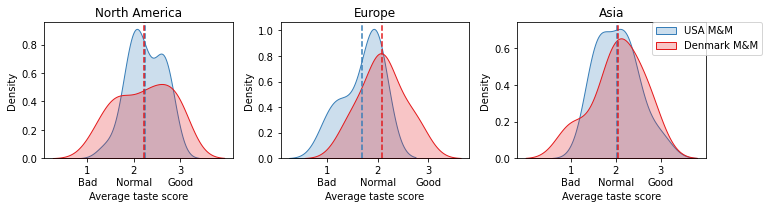

In [74]:
# plot density of each continent's response to each M&M
color_origin = sns.color_palette('Set1')
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,3))

# Left plot
sns.kdeplot(x=na_m1,fill=True,ax=ax1,color=color_origin[1],label="USA M&M")
sns.kdeplot(x=na_m2,fill=True,ax=ax1,color=color_origin[0],label="Denmark M&M")

ax1.axvline(np.mean(na_m1),c=color_origin[1],linestyle='--')
ax1.axvline(np.mean(na_m2),c=color_origin[0],linestyle='--')
ax1.set_title("North America")
ax1.set_xlabel("Average taste score")
ax1.set_xticks([1,2,3])
labels = ['1\nBad', '2\nNormal','3\nGood']
ax1.set_xticklabels(labels)

# Middle plot
sns.kdeplot(x=eu_m1,fill=True,ax=ax2,color=color_origin[1])
sns.kdeplot(x=eu_m2,fill=True,ax=ax2,color=color_origin[0])

ax2.axvline(np.mean(eu_m1),c=color_origin[1],linestyle='--')
ax2.axvline(np.mean(eu_m2),c=color_origin[0],linestyle='--')
ax2.set_title("Europe")
ax2.set_xlabel("Average taste score")
ax2.set_xticks([1,2,3])
labels = ['1\nBad', '2\nNormal','3\nGood']
ax2.set_xticklabels(labels)


# Right plot
sns.kdeplot(x=as_m1,fill=True,ax=ax3,color=color_origin[1])
sns.kdeplot(x=as_m2,fill=True,ax=ax3,color=color_origin[0])

ax3.axvline(np.mean(as_m1),c=color_origin[1],linestyle='--')
ax3.axvline(np.mean(as_m2),c=color_origin[0],linestyle='--')
ax3.set_title("Asia")
ax3.set_xlabel("Average taste score")
ax3.set_xticks([1,2,3])
labels = ['1\nBad', '2\nNormal','3\nGood']
ax3.set_xticklabels(labels)

plt.tight_layout()
fig.legend(bbox_to_anchor=(0.91, 0.88), loc='upper left', borderaxespad=0)
fig.savefig('figs/mnm_kde_ave_score_by_cont.jpg',dpi=200,bbox_inches = "tight")


#### T-test diffs between continents for same M&M

In [35]:
eu_na_m1_pval = stats.ttest_ind(a=eu_m1, b=na_m1, equal_var=True)[1]
eu_na_m2_pval = stats.ttest_ind(a=eu_m2, b=na_m2, equal_var=True)[1]

eu_as_m1_pval = stats.ttest_ind(a=eu_m1, b=as_m1, equal_var=True)[1]
eu_as_m2_pval = stats.ttest_ind(a=eu_m2, b=as_m2, equal_var=True)[1]

as_na_m1_pval = stats.ttest_ind(a=as_m1, b=na_m1, equal_var=True)[1]
as_na_m2_pval = stats.ttest_ind(a=as_m2, b=na_m2, equal_var=True)[1]

print(f"The p-value for European vs North American average taste scores for M1 (USA):{eu_na_m1_pval:.3f}")
print(f"The p-value for European vs North American average taste scores for M2 (Denmark):{eu_na_m2_pval:.3f}")
print()

print(f"The p-value for European vs Asian average taste scores for M1 (USA):{eu_as_m1_pval:.3f}")
print(f"The p-value for European vs Asian average taste scores for M2 (Denmark):{eu_as_m2_pval:.3f}")
print()

print(f"The p-value for North American vs Asian average taste scores for M1 (USA):{as_na_m1_pval:.3f}")
print(f"The p-value for North American vs Asian average taste scores for M2 (Denmark):{as_na_m2_pval:.3f}")

The p-value for European vs North American average taste scores for M1 (USA):0.001
The p-value for European vs North American average taste scores for M2 (Denmark):0.588

The p-value for European vs Asian average taste scores for M1 (USA):0.080
The p-value for European vs Asian average taste scores for M2 (Denmark):0.838

The p-value for North American vs Asian average taste scores for M1 (USA):0.114
The p-value for North American vs Asian average taste scores for M2 (Denmark):0.404


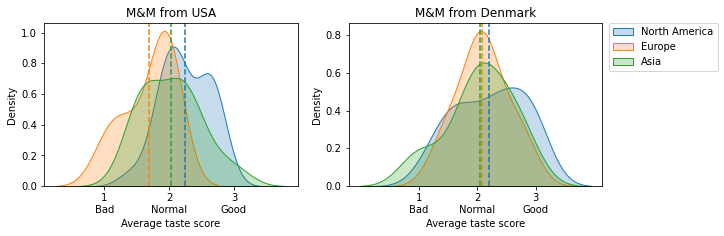

In [36]:
colors = sns.color_palette('tab10')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3))

# Left plot
sns.kdeplot(x=pdf[pdf['continent_adj']=="North America"]['m1_ave'],
            fill=True,ax=ax1,label='North America')
sns.kdeplot(x=pdf[pdf['continent_adj']=="Europe"]['m1_ave'],
            fill=True,ax=ax1,label='Europe')
sns.kdeplot(x=pdf[pdf['continent_adj']=="Asia"]['m1_ave'],
            fill=True,ax=ax1,label='Asia')

ax1.axvline(np.mean(na_m1),c=colors[0],linestyle='--')
ax1.axvline(np.mean(eu_m1),c=colors[1],linestyle='--')
ax1.axvline(np.mean(as_m1),c=colors[2],linestyle='--')

ax1.set_title("M&M from USA")
ax1.set_xlabel("Average taste score")
ax1.set_xticks([1,2,3])
labels = ['1\nBad', '2\nNormal','3\nGood']
ax1.set_xticklabels(labels)

# Right plot
sns.kdeplot(data=pdf[pdf['continent_adj']=="North America"]['m2_ave'],
            fill=True,ax=ax2)
sns.kdeplot(data=pdf[pdf['continent_adj']=="Europe"]['m2_ave'],
            fill=True,ax=ax2)
sns.kdeplot(data=pdf[pdf['continent_adj']=="Asia"]['m2_ave'],
            fill=True,ax=ax2)

ax2.axvline(np.mean(na_m2),c=colors[0],linestyle='--')
ax2.axvline(np.mean(eu_m2),c=colors[1],linestyle='--')
ax2.axvline(np.mean(as_m2),c=colors[2],linestyle='--')

ax2.set_title("M&M from Denmark")
ax2.set_xlabel("Average taste score")
ax2.set_xticks([1,2,3])
labels = ['1\nBad', '2\nNormal','3\nGood']
ax2.set_xticklabels(labels)

fig.legend(bbox_to_anchor=(0.91, 0.88), loc='upper left', borderaxespad=0)
fig.savefig('figs/mnm_kde_ave_score.jpg',dpi=200,bbox_inches = "tight")

# Results 3.3

### M&M Enjoyment alignment chart 

In [42]:
# Average
interval = alt.selection_interval()

scatter = alt.Chart(pdf).mark_point(size=200).encode(
    x=alt.X('m1_ave',title="USA M&M average taste score",
            axis=alt.Axis(titleFontSize=14,values=[1,1.5,2,2.5,3])
           ).scale(domain=(0.8, 3.2)),
    y=alt.Y('m2_ave',title="Denmark M&M average taste score",
            axis=alt.Axis(titleFontSize=14,values=[1,1.5,2,2.5,3])
           ).scale(domain=(0.8, 3.2)),
    color=alt.Color('continent_adj',title='',
                    legend=alt.Legend(
                        orient='none',
                        legendX=30, legendY=-20,
                        direction='horizontal',
                        titleAnchor='middle')
                   ).scale(scheme="category10",
                           domain=['North America','Europe','Asia','Aus/SA']),
    shape=alt.Shape('continent_adj').scale(domain=['North America','Europe','Asia','Aus/SA']),
    opacity=alt.condition(interval, alt.value(.8), alt.value(0.2)),
    tooltip=['participant_id',alt.Tooltip('m1_ave',title="USA M&M ave score"),
             alt.Tooltip('m2_ave',title="DEN M&M ave score"),alt.Tooltip('mnm_ratio',format='.2f',title="M&M preference ratio")]
).add_params(
    interval
)

h2 = alt.Chart(pd.DataFrame({'y': [2]})).mark_rule(color='gray',strokeWidth=1).encode(y='y')
v2 = alt.Chart(pd.DataFrame({'x': [2]})).mark_rule(color='gray',strokeWidth=1).encode(x='x')
h15 = alt.Chart(pd.DataFrame({'y': [1.5]})).mark_rule(color='lightgray',strokeDash=[3,1]).encode(y='y')
v15 = alt.Chart(pd.DataFrame({'x': [1.5]})).mark_rule(color='lightgray',strokeDash=[3,1]).encode(x='x')
h25 = alt.Chart(pd.DataFrame({'y': [2.5]})).mark_rule(color='lightgray',strokeDash=[3,1]).encode(y='y')
v25 = alt.Chart(pd.DataFrame({'x': [2.5]})).mark_rule(color='lightgray',strokeDash=[3,1]).encode(x='x')

scatter_lines = scatter + h2 + v2 + h15 + v15 + h25 + v25 

hist_back = alt.Chart(pdf).mark_bar(size=55).encode(
    y=alt.Y('continent_adj',sort='descending'),
    x=alt.X('count()').scale(domain=(0, 26)),
    color=alt.Color('continent_adj',legend=None).scale(
        scheme='category10',
        domain=['North America','Europe','Asia','Aus/SA']),
    opacity=alt.value(0.2)
).properties(
    height=300,
    width=200
)

hist_front = alt.Chart(pdf).mark_bar(size=55).encode(
    y=alt.Y('continent_adj',title='',sort='descending',axis=alt.Axis(labelFontSize=12)
           ).scale(domain=['North America','Europe','Asia','Aus/SA']),
    x=alt.X('count()',title="Count of Participants",
            axis=alt.Axis(titleFontSize=14)).scale(domain=(0, 26)),
    color=alt.Color('continent_adj')
).transform_filter(
    interval
).properties(
    height=300
)

count_text = alt.Chart(pdf).mark_text(dx=1,align='left',size=12).encode(
     x=alt.X('count()').stack('zero'),
     y=alt.Y('continent_adj',title="",axis=alt.Axis(labelFontSize=14)),
    #detail='data_collection:N',
    color='continent_adj',
    text=alt.Text('count():Q')
).transform_filter(
    interval
)

hist = hist_back + hist_front + count_text

chart = alt.hconcat(scatter_lines,hist).configure_axis(
     grid=False
).resolve_scale(
    color='independent',
    shape='independent'
)
chart.save('figs/scatter_brush_bar_pref.html')
chart.save('json/fig7_scatter_brush_bar_pref.json')
chart

alt.HConcatChart(...)

Interactive altair chart: brush over scatterplot to see bar chart counts respond

In [43]:
# uncombined chart for adding alignment notations in ppt
scatter_lines.configure_axis(
     grid=False
)

alt.LayerChart(...)

# Results 3.4
Plot the distribution of participants' M&M preference ratios by continent.

The average taste score doesn't account for Person 1 saying European M&Ms are "Good" and American M&Ms are "Normal", vs Person 2 saying European M&Ms are "Normal" and American M&Ms are "Bad." This is the same relative preference but, Person 2 just likes M&Ms less than Person 1

Since peoples baseline M&M enjoyement might be different, the ratio of taste scores is perhaps more indicative of relative preference than the average score.

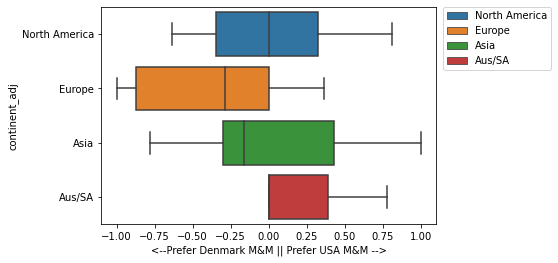

In [44]:
# box plot
sns.boxplot(data=pdf, x='mnm_ratio',y='continent_adj',hue='continent_adj',dodge=False)
plt.xlabel("<--Prefer Denmark M&M || Prefer USA M&M -->")

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

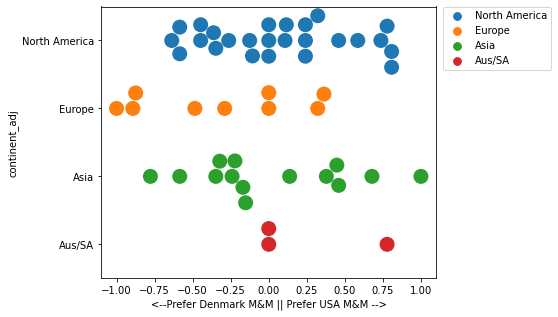

In [45]:
# swarm plot
fig = plt.figure(figsize=(6,5))
sns.swarmplot(data=pdf, x='mnm_ratio',hue='continent_adj',
              size=15,y='continent_adj')
plt.xlabel("<--Prefer Denmark M&M || Prefer USA M&M -->")

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

Combine box and swarm plots

In [46]:
# make a light color palette of seaborn Tab10 (which is Altair's Category10, btw)
# for lightening box plot boxes
lighter_tab10 = []
lighten = 3.7
for x in sns.color_palette("tab10"):
    lightx = sns.light_palette(x)[2]
    lighter_tab10.append(lightx)
    
lighter_tab10 = sns.color_palette(lighter_tab10)
lighter_tab10

[(0.6121039346949929, 0.7530476680842987, 0.8532170068730586),
 (0.9713871486660464, 0.7640327719390043, 0.5849483916608107),
 (0.6225213643910119, 0.8219878478064994, 0.6224676430521614),
 (0.9063080984539633, 0.6260418291993344, 0.6275445674850794),
 (0.7990828098731056, 0.7271493547150166, 0.8651430051394642),
 (0.7878975533800828, 0.7004382404275995, 0.6827361267749749),
 (0.9257400290000436, 0.751524755314482, 0.8720379078525452),
 (0.7652971203642703, 0.7653158978655056, 0.7652422055584429),
 (0.8637741409534866, 0.8659014670566446, 0.5757931206055269),
 (0.5920867224153922, 0.8665751056960371, 0.8958177569731581)]

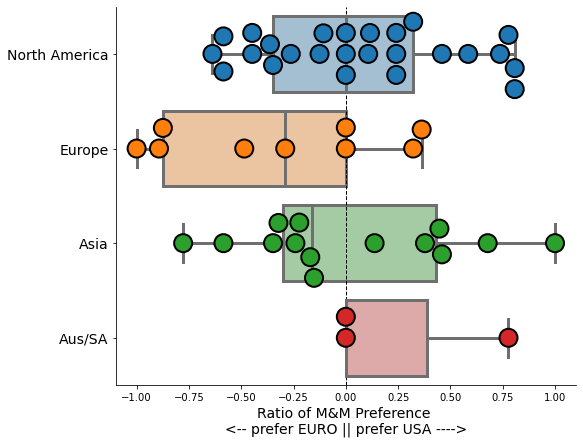

In [47]:
# swarm box overlay
g = sns.catplot(
    data=pdf, x='mnm_ratio', y='continent_adj',
    kind='box',palette=lighter_tab10,
    boxprops=dict(alpha=1),height=6,aspect=8/6,linewidth=3,
)
g.map_dataframe(sns.swarmplot, x='mnm_ratio', y='continent_adj',
                size=18, #alpha=0.99,
                edgecolor='black',linewidth=2, dodge=True,
                palette='tab10',
               )

plt.axvline(0,color='black',linestyle='--',linewidth=1)
plt.xlabel("Ratio of M&M Preference \n<-- prefer EURO || prefer USA ---->",fontsize=14)
plt.ylabel("")
plt.yticks(fontsize=14)
g.savefig('figs/mnm_pref_box_swarm_ratio.jpg',dpi=200)
plt.show()

#### Same distribution plots but using the difference in M&M taste score sums instead of ratio of average scores

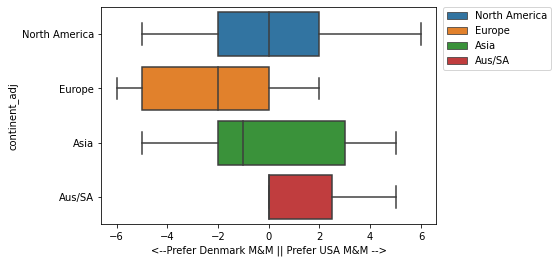

In [48]:
# box plot
sns.boxplot(data=pdf, x='mnm_diff',y='continent_adj',hue='continent_adj',dodge=False)
plt.xlabel("<--Prefer Denmark M&M || Prefer USA M&M -->")

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

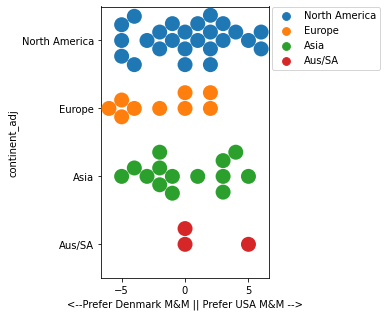

In [49]:
# swarm plot
fig = plt.figure(figsize=(3,5))
sns.swarmplot(data=pdf, x='mnm_diff',hue='continent_adj',
              size=15,y='continent_adj')
plt.xlabel("<--Prefer Denmark M&M || Prefer USA M&M -->")

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

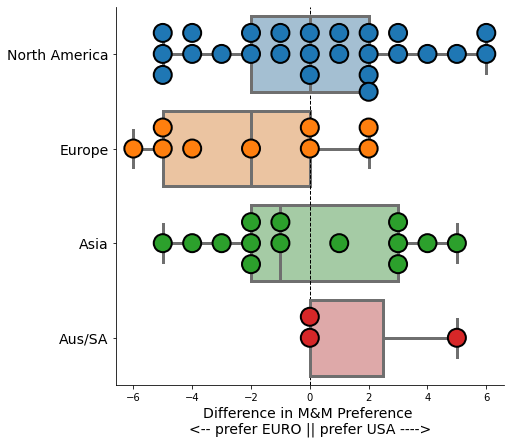

In [50]:
# swarm box overlay
g = sns.catplot(
    data=pdf, x='mnm_diff', y='continent_adj',
    kind='box',palette=lighter_tab10,
    boxprops=dict(alpha=1),height=6,aspect=7/6,linewidth=3,
)
g.map_dataframe(sns.swarmplot, x='mnm_diff', y='continent_adj',
                size=18, #alpha=0.99,
                edgecolor='black',linewidth=2, dodge=True,
                palette='tab10',
               )

plt.axvline(0,color='black',linestyle='--',linewidth=1)
plt.xlabel("Difference in M&M Preference \n<-- prefer EURO || prefer USA ---->",fontsize=14)
plt.ylabel("")
plt.yticks(fontsize=14)
g.savefig('figs/mnm_pref_box_swarm_diff.jpg',dpi=200)
plt.show()

### T-test on the distribution of preference ratios between continents

In [51]:
na_ratios = pdf[pdf['continent_adj']=="North America"]['mnm_ratio'].values
eu_ratios = pdf[pdf['continent_adj']=="Europe"]['mnm_ratio'].values
as_ratios = pdf[pdf['continent_adj']=="Asia"]['mnm_ratio'].values

eu_na_ratio_pval = stats.ttest_ind(a=eu_ratios, b=na_ratios, equal_var=True)[1]
print(f"The p-value for European vs North American ratios:{eu_na_ratio_pval:.3f}")


eu_as_ratio_pval = stats.ttest_ind(a=eu_ratios, b=as_ratios, equal_var=True)[1]
print(f"The p-value for European vs Asia ratios:{eu_as_ratio_pval:.3f}")


as_na_ratio_pval = stats.ttest_ind(a=as_ratios, b=na_ratios, equal_var=True)[1]
print(f"The p-value for Asia vs North American ratios:{as_na_ratio_pval:.3f}")


The p-value for European vs North American ratios:0.049
The p-value for European vs Asia ratios:0.140
The p-value for Asia vs North American ratios:0.798


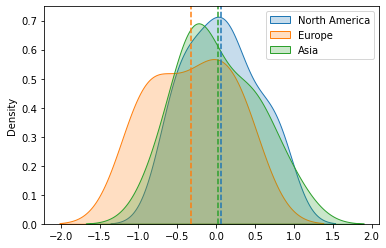

In [52]:
sns.kdeplot(x=na_ratios,fill=True,label='North America')
sns.kdeplot(x=eu_ratios,fill=True,label='Europe')
sns.kdeplot(x=as_ratios,fill=True,label='Asia')
# sns.kdeplot(x=pdf[pdf['continent_adj']=="Aus/SA"]['mnm_ratio'],
#             fill=True,label='Aus/SA')

plt.axvline(np.mean(na_ratios),c=colors[0],linestyle='--')
plt.axvline(np.mean(eu_ratios),c=colors[1],linestyle='--')
plt.axvline(np.mean(as_ratios),c=colors[2],linestyle='--')


plt.legend()


In [53]:
# one sided t-test --> Is Europe's distribution of preference ratios different than 0.0?
print(eu_ratios)
stats.ttest_1samp(eu_ratios, popmean=0.0)

[-1.          0.36257008 -0.87446912 -0.8930848   0.32192809  0.
  0.         -0.48542683 -0.28950662]


TtestResult(statistic=-1.8128386527594693, pvalue=0.10742308942195414, df=8)

# Results 3.5 
Use participants' standard deviation of taste scores to determine how consistent people were in their responses.

High average standard deviation means they responded more differently when tasting M&MS of the same type. An average standard devation of 0 means the participant was SUPER consistent (like a perfect M&M classifier).

In [62]:
chart = alt.Chart(pdf).mark_point(size=200).encode(
    x=alt.X('mnm_ratio',axis=alt.Axis(
        title=["M&M Preference Ratio","<-- Prefer EURO || Prefer USA --->"],
        titleFontSize=14
    )).scale(domain=(-1.1, 1.1)),
    y=alt.Y('ave_std',axis=alt.Axis(
        title=["Taste response consistency","(ave stdev of M&M scores)"],
        titleFontSize=14
    )).scale(domain=(-0.1, 1.1)),
    color=alt.Color('continent_adj',title='',
                   legend=alt.Legend(
                        orient='none',
                        legendX=120, legendY=-20,
                        direction='horizontal',
                        titleAnchor='middle')
                   ).scale(
        scheme='category10',
        domain=['North America','Europe','Asia','Aus/SA']),
    shape=alt.Shape('continent_adj').scale(domain=['North America','Europe','Asia','Aus/SA']),
    tooltip=['participant_id',alt.Tooltip('m1_ave',title="USA M&M ave score"),
             alt.Tooltip('m2_ave',title="DEN M&M ave score"),alt.Tooltip('mnm_ratio',format='.2f',title="M&M preference ratio")]
).interactive().properties(
    width=500,
    height=300
)

chart.save('figs/participant_consistency_pref_ratio.html')
chart.save('json/fig9_participant_consistency_pref_ratio.json')

chart

alt.Chart(...)

# Results 3.6
## Is there a difference in taste reponse to M&M's of different colors?

In [63]:
alt.Chart(df).mark_bar(size=35).encode(
    x=alt.X('mnm_origin:N',title="M&M origin",axis=alt.Axis(labelAngle=0,labelFontSize=10),sort='descending'),
    y=alt.Y('count(taste_response)',title="Percent of Responses").stack('normalize'),
    color=alt.Color('taste_response:N',sort=taste_order,title="Taste").scale(scheme='brownbluegreen'),
    order=alt.Order('color_taste_response_sort_index:Q',sort='descending'),
    column=alt.Column('mnm_color:N',title='',header=alt.Header(labelFontSize=18))
).properties(width=80)

alt.Chart(...)

In [64]:
alt.Chart(df).mark_bar(size=25).encode(
    x=alt.X('mnm_color:N',title="M&M color",axis=alt.Axis(labelAngle=0,labelFontSize=10)),
    y=alt.Y('count(taste_response)',title="Percent of Responses").stack('normalize'),
    color=alt.Color('taste_response:N',sort=taste_order,title="Taste").scale(scheme='brownbluegreen'),
    order=alt.Order('color_taste_response_sort_index:Q',sort='descending'),
    column=alt.Column('mnm_origin:N',title='M&M Origin',header=alt.Header(labelFontSize=14,titleFontSize=14),sort='descending')
).properties(width=190)

alt.Chart(...)

### Sampling distribution of M&Ms of different colors

In [65]:
alt.Chart(df).mark_bar(size=25).encode(
    x=alt.X('mnm_color:N',title="M&M color",axis=alt.Axis(labelAngle=0,labelFontSize=10)),
    y=alt.Y('count(taste_response)',title="Percent of Responses"),
    color=alt.Color('taste_response:N',sort=taste_order,title="Taste").scale(scheme='brownbluegreen'),
    order=alt.Order('color_taste_response_sort_index:Q',sort='descending'),
    column=alt.Column('mnm_origin:N',title='M&M Origin',header=alt.Header(labelFontSize=10),sort='descending'),
    tooltip=['taste_response','count(taste_response)']
).properties(width=190)

alt.Chart(...)

In [66]:
# corporate coloring
mnm_domain = ['blue','brown','green','orange','red','yellow']
mnm_range = ['#055db5','#603a34','#31ac55','#f26f22','#b11224','#e8ca07']
   
alt.Chart(df).mark_bar(size=30).encode(
    x=alt.X('mnm_color:N',title="M&M color",axis=alt.Axis(labelAngle=0,labelFontSize=10)),
    y=alt.Y('count(mnm_color)',title="Count of M&Ms sampled"),
    color=alt.Color('mnm_color:N',legend=None).scale(domain=mnm_domain,range=mnm_range),
    #order=alt.Order('color_taste_response_sort_index:Q',sort='descending'),
    column=alt.Column('mnm_origin:N',title='M&M Origin',header=alt.Header(labelFontSize=14,titleFontSize=14),sort='descending'),
    tooltip=['mnm_color','count(mnm_color)']
).properties(width=210,height=200)

alt.Chart(...)

Most M&M colors were sampled fairly evenly, however there appears to be a skew towards an increased frequency of Blue M&M samples when experimenters drew from the USA-sourced M&M bag.

In [67]:
# Difference in color response by continent...?
# data is too sparse

alt.Chart(df).mark_bar(size=25).encode(
    x=alt.X('mnm_origin:N',title="M&M Origin",axis=alt.Axis(labelAngle=0,labelFontSize=10),sort='descending'),
    y=alt.Y('count(taste_response)',title="").stack("normalize"),
    color=alt.Color('taste_response:N',sort=taste_order,title="Taste").scale(scheme='brownbluegreen'),
    order=alt.Order('color_taste_response_sort_index:Q',sort='descending'),
    column=alt.Column('mnm_color:N',title='M&M Color',header=alt.Header(labelFontSize=10)),
    row=alt.Row('continent_adj:N',title='Percent of Responses',sort='descending'),
    tooltip=[alt.Tooltip('continent_adj',title="Participant continent"),'taste_response','count(taste_response)']
).properties(width=75,height=75)

alt.Chart(...)

# Results 3.7
## Just for fun, generate a word cloud from "notes" column for M&M responses

In [68]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [69]:
# USA M&M participant response notes
m1_notes = [x for x in df[df['mnm_id']==1]['notes'] if x != '']
m1_notes

['still taste the chemical but not as bad as the last one',
 'outside better, candy shell is worse',
 'bad bad',
 'not as bad',
 'very bad ',
 'would still eat',
 "That's digusting",
 'Kinda bad',
 'Gags',
 'Disgusting',
 'Old mnm ',
 'Tastes a bit different but still normal',
 'Something different',
 'REALLY bad',
 'a bit weird',
 'Sweet',
 "I don't like this one",
 'more crunchy',
 'weird flavor',
 'extra sweet',
 'extra sweet',
 'sweeter than before',
 'same as last one',
 'taste is different from all the previous ones',
 "dude that's some euro trash right there",
 'air quotes on the good',
 'am I imagining shit?',
 'like the first one',
 'chocolate was bad',
 'very good',
 'for sure',
 'delicious']

In [70]:
# Denmark M&M participant response notes
m2_notes = [x for x in df[df['mnm_id']==2]['notes'] if x != '']
m2_notes

['very diffferent than any previous',
 'a lot better than the previous ones',
 'different taste but different than the other different tastes',
 'actually quite bad',
 "different than previous i haven't been shocked, like OMG",
 'Tastes like European smarties, or Canadian ',
 'Like coconut',
 'Smartie again ',
 'Coconut',
 'On the shit side',
 'That was worse',
 'Really good',
 'Really good',
 'weirdly lemony',
 'a little carmely',
 'has a synthetic taste',
 'less sweet',
 'terrible',
 'really like that, extremely good',
 'extremely good',
 'same as first one',
 'probably bad',
 "that's some american garbage right there",
 "euro trash!... actually, i'm confused",
 "I'm more of a skittles guy",
 'same as last one',
 'not bad also',
 'good at first but weird aftertaste',
 'started off bad and it got better',
 'pretty sure that was different than the first one',
 'similar to the second one',
 "I think I can't tell anymore",
 'baseline',
 'chocolate much better',
 'very good',
 'quick resp

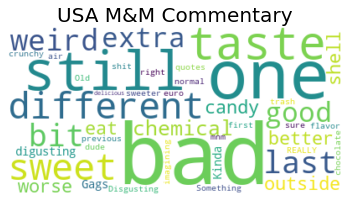

In [71]:
text = " ".join(note for note in m1_notes)

# Create and generate a word cloud image:
wordcloud = WordCloud(
    max_font_size=100,
    max_words=50,
    background_color='white'
).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("USA M&M Commentary", fontsize=20)
plt.show()

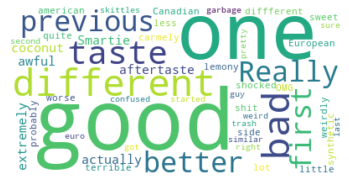

In [72]:
text = " ".join(note for note in m2_notes)

# Create and generate a word cloud image:
wordcloud = WordCloud(
    max_font_size=100,
    max_words=50,
    background_color='white'
).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

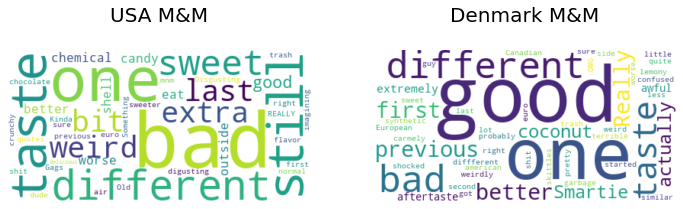

In [73]:
text1 = " ".join(note for note in m1_notes)

# Create and generate a word cloud image:
wordcloud1 = WordCloud(
    max_font_size=100,
    max_words=50,
    background_color='white'
).generate(text1)

text2 = " ".join(note for note in m2_notes)

# Create and generate a word cloud image:
wordcloud2 = WordCloud(
    max_font_size=100,
    max_words=50,
    background_color='white'
).generate(text2)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))
# Display the generated image:
ax1.imshow(wordcloud1, interpolation='bilinear')
ax2.imshow(wordcloud2, interpolation='bilinear')
ax1.axis("off")
ax2.axis('off')
ax1.set_title("USA M&M\n", fontsize=20)
ax2.set_title("Denmark M&M\n", fontsize=20)
fig.savefig('figs/word_cloud.jpg',dpi=200)
plt.show()

Maybe if I was in NLP, I'd put effort into sentiment analysis, but alas, I'm a biologist and that all the analysis I had courage to do for now :P 

Thanks for following along!

# Scratch work

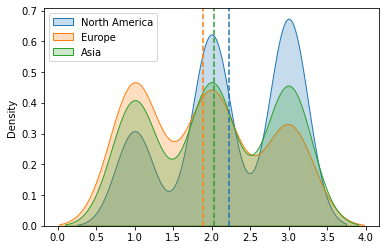

In [73]:
# look at the density just of the taste scores?
# the loopy distribution doesn't really make sense here because all
# values are integers at 1, 2, or 3... but you can kinda see that 
# North Americans most often gave "Good" responses while Europeans
# most often gave "Bad respsonses"

na_scores = df[df['continent_adj']=="North America"]['taste_score'].values
eu_scores = df[df['continent_adj']=="Europe"]['taste_score'].values
as_scores = df[df['continent_adj']=="Asia"]['taste_score'].values

sns.kdeplot(x=na_scores,fill=True,label='North America')
sns.kdeplot(x=eu_scores,fill=True,label='Europe')
sns.kdeplot(x=as_scores,fill=True,label='Asia')
# sns.kdeplot(x=pdf[pdf['continent_adj']=="Aus/SA"]['mnm_ratio'],
#             fill=True,label='Aus/SA')

plt.axvline(np.mean(na_scores),c=colors[0],linestyle='--')
plt.axvline(np.mean(eu_scores),c=colors[1],linestyle='--')
plt.axvline(np.mean(as_scores),c=colors[2],linestyle='--')


plt.legend(loc='upper left')

### What is the effect size you can measure?

In [38]:
power_analysis = smp.TTestIndPower()
sample_size_eff5 = power_analysis.solve_power(effect_size=0.5, power=0.8, alpha=0.05)
sample_size_eff6 = power_analysis.solve_power(effect_size=0.6, power=0.8, alpha=0.05)

print(f"We can measure an effect size of 0.5 at power 0.8 with {sample_size_eff5:.1f} samples,")
print(f"or an effect size of 0.6 at power 0.8 with {sample_size_eff6:.1f} samples")
print(f"(Our sample size is {len(participants)})")

We can measure an effect size of 0.5 at power 0.8 with 63.8 samples,
or an effect size of 0.6 at power 0.8 with 44.6 samples
(Our sample size is 51)


### How aligned are participants ratio vs difference scores?

<Axes: xlabel='mnm_diff', ylabel='mnm_ratio'>

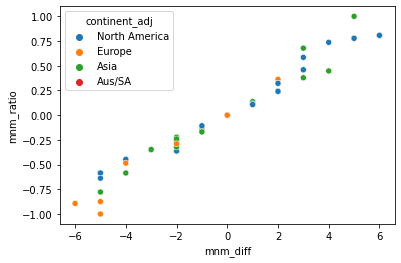

In [74]:
sns.scatterplot(data=pdf,x='mnm_diff',y='mnm_ratio',hue='continent_adj')

## Do the results change if you chop off the first 4 of each participant?
Maybe they gained clarity after tasting at least 1 of each type of M&M?

But by chopping 4 off the front, we're not guaranteed that the total amount of M&Ms tasted of each type remains the same... did not pursue analysis further but maybe there's better normalization that can be done.

In [267]:
df_chop4 = pd.DataFrame()
for g,d in dfp:
    df_chop4 = pd.concat([df_chop4,d.tail(6)])
    
df_chop4.head(14)

,participant_id,mnm_id,mnm_color,taste_response,notes,continent,mnm_origin,continent_adj,taste_score
4,1,1,yellow,bad,,North America,USA,North America,1
5,1,2,red,good,very diffferent than any previous,North America,Denmark,North America,3
6,1,2,yellow,bad,,North America,Denmark,North America,1
7,1,1,red,normal,,North America,USA,North America,2
8,1,1,brown,bad,,North America,USA,North America,1
9,1,2,blue,bad,,North America,Denmark,North America,1
14,2,2,red,normal,,Europe,Denmark,Europe,2
15,2,1,green,bad,,Europe,USA,Europe,1
16,2,2,brown,normal,,Europe,Denmark,Europe,2
17,2,2,orange,normal,,Europe,Denmark,Europe,2


In [268]:

alt.Chart(df_chop4).mark_bar(size=90).encode(
    x=alt.X('mnm_origin:N',title="M&M origin",axis=alt.Axis(labelAngle=0)),
    y=alt.Y('count(taste_response)',title="Percent of Responses").stack('normalize'),
    color=alt.Color('taste_response:N',sort=taste_order,title="Taste").scale(scheme='brownbluegreen'),
    order=alt.Order('color_taste_response_sort_index:Q',sort='descending')
).properties(width=210)

alt.Chart(...)

In [269]:
alt.Chart(df_chop4).mark_bar(size=40).encode(
    x=alt.X('mnm_origin:N',title="M&M origin",axis=alt.Axis(labelAngle=0,labelFontSize=10)),
    y=alt.Y('count(taste_response)',title="Percent of Responses").stack('normalize'),
    color=alt.Color('taste_response:N',sort=taste_order,title="Taste").scale(scheme='brownbluegreen'),
    order=alt.Order('color_taste_response_sort_index:Q',sort='descending'),
    column=alt.Column('continent_adj:N',title='',header=alt.Header(labelFontSize=18),sort='descending'),
    tooltip=['continent_adj','taste_response','mnm_origin','count(taste_response)']
).properties(
    width=100,
    height=180
)

alt.Chart(...)

In [270]:
df_chop4_filt = df_chop4[df_chop4['continent_adj'] != 'Aus/SA']
order = ['bad','normal','good']

alt.Chart(df_chop4_filt).mark_bar(size=70).encode(
    x=alt.X('continent_adj:N',title="Participant continent",axis=alt.Axis(labelAngle=0,labelFontSize=10)),
    y=alt.Y('count(taste_response)',title="Percent of Responses").stack('normalize'),
    color=alt.Color('taste_response:N',sort=order,title="Taste").scale(scheme='brownbluegreen'),
    order=alt.Order('color_taste_response_sort_index:Q',sort='descending'),
    column=alt.Column('mnm_origin:N',title='M&M Origin',
                      header=alt.Header(labelFontSize=18,titleFontSize=14),sort='descending'),
    tooltip=['continent_adj','taste_response','mnm_origin','count(taste_response)']
).properties(width=250, height=200)

alt.Chart(...)

In [271]:
w = 60
h = 80

eu = alt.Chart(df_chop4[df_chop4['continent_adj']=='Europe'],).mark_bar(size=30).encode(
    alt.Y("count(taste_response):N",title="Count"),
    alt.X("mnm_origin",title='',sort=order,axis=alt.Axis(labels=False)),
    alt.Color("mnm_origin:N",title='M&M Origin'),
    alt.Column("taste_response:N",sort=order,spacing=2,
               header=alt.Header(labelFontSize=14,title='Europe',titleFontSize=20)),
).properties(
    width=w,
    height=h,
)

na = alt.Chart(df_chop4[df_chop4['continent_adj']=='North America'],).mark_bar(size=30).encode(
    alt.Y("count(taste_response):N",title="Count"),
    alt.X("mnm_origin",sort=order,title='',axis=alt.Axis(labels=False)),
    alt.Color("mnm_origin:N"),
    alt.Column("taste_response:N",sort=order,spacing=2,
               header=alt.Header(labelFontSize=14,title='North America',titleFontSize=20)),
).properties(
    width=w,
    height=h,
)

asi = alt.Chart(df_chop4[df_chop4['continent_adj']=='Asia'],).mark_bar(size=30).encode(
    alt.Y("count(taste_response):N",title="Count"),
    alt.X("mnm_origin",sort=order,title=''),
    alt.Color("mnm_origin:N"),
    alt.Column("taste_response:N",sort=order,spacing=2,
               header=alt.Header(labelFontSize=14,title='Asia',titleFontSize=20)),
).properties(
    width=w,
    height=h,
)

ausa = alt.Chart(df_chop4[df_chop4['continent_adj']=='Aus/SA'],).mark_bar(size=30).encode(
    alt.Y("count(taste_response):N",title="Count"),
    alt.X("mnm_origin",title='',),
    alt.Color("mnm_origin:N"),
    alt.Column("taste_response:N",sort=order,spacing=2,
               header=alt.Header(labelFontSize=14,title='Aus/SA',titleFontSize=20)),
    order=alt.Order('column_taste_response_sort_index:Q')
).properties(
    width=w,
    height=h,
)

euna = alt.hconcat(eu,na)
aa = alt.hconcat(asi,ausa)
alt.vconcat(euna,aa
).configure_axis(
    grid=False,
)

alt.VConcatChart(...)

In [272]:
dfp_chop4 = df_chop4.groupby('participant_id')


In [273]:
p_score_data_chop4 = []
for p in dfp_chop4.groups:
    p_df = dfp_chop4.get_group(p)
    
    m1_vals = p_df[p_df['mnm_id']==1]['taste_score'].values
    m1_sum = sum(m1_vals)
    m1_ave = np.mean(m1_vals)
    m1_std = np.std(m1_vals)
    
    m2_vals = p_df[p_df['mnm_id']==2]['taste_score'].values
    m2_sum = sum(m2_vals)
    m2_ave = np.mean(m2_vals)
    m2_std = np.std(m2_vals)
    
    row = [p,m1_sum,m1_ave,m1_std,m2_sum,m2_ave,m2_std]
    p_score_data_chop4.append(row)

p_score_df_chop4 = pd.DataFrame(p_score_data_chop4, columns=[
    'participant_id',
    'm1_sum',
    'm1_ave',
    'm1_std',
    'm2_sum',
    'm2_ave',
    'm2_std'
])

pdf_chop4 = pd.merge(
    p_score_df_chop4,
    participants,
    how="inner",
    on='participant_id')
pdf_chop4.head()

,participant_id,m1_sum,m1_ave,m1_std,m2_sum,m2_ave,m2_std,continent_of_origin,data_collection,continent_adj
0,1,4,1.333333,0.471405,5,1.666667,0.942809,North America,collected in Lyngby,North America
1,2,3,1.000000,0.000000,6,2.000000,0.000000,Europe,collected in Lyngby,Europe
2,3,7,2.333333,0.942809,5,1.666667,0.942809,North America,collected in Lyngby,North America
3,4,3,1.500000,0.500000,6,1.500000,0.500000,Europe,collected in Lyngby,Europe
4,5,4,1.000000,0.000000,4,2.000000,0.000000,Europe,collected in Lyngby,Europe


In [275]:
pdf_chop4['mnm_diff'] = pdf_chop4.apply(lambda row: row['m1_sum'] - row['m2_sum'],axis=1)
pdf_chop4['mnm_ratio'] = pdf_chop4.apply(lambda row: np.log2(row['m1_ave']/row['m2_ave']),axis=1)
pdf_chop4['ave_std'] = pdf_chop4.apply(lambda row: np.mean([row['m1_std'], row['m2_std']]),axis=1)
pdf_chop4

,participant_id,m1_sum,m1_ave,m1_std,m2_sum,m2_ave,m2_std,continent_of_origin,data_collection,continent_adj,mnm_skew,mnm_ratio,ave_std,mnm_diff
0,1,4,1.333333,0.471405,5,1.666667,0.942809,North America,collected in Lyngby,North America,-1,-0.321928,0.707107,-1
1,2,3,1.000000,0.000000,6,2.000000,0.000000,Europe,collected in Lyngby,Europe,-3,-1.000000,0.000000,-3
2,3,7,2.333333,0.942809,5,1.666667,0.942809,North America,collected in Lyngby,North America,2,0.485427,0.942809,2
3,4,3,1.500000,0.500000,6,1.500000,0.500000,Europe,collected in Lyngby,Europe,-3,0.000000,0.500000,-3
4,5,4,1.000000,0.000000,4,2.000000,0.000000,Europe,collected in Lyngby,Europe,0,-1.000000,0.000000,0
5,6,5,2.500000,0.500000,10,2.500000,0.500000,North America,collected in Lyngby,North America,-5,0.000000,0.500000,-5
6,7,7,1.750000,0.433013,3,1.500000,0.500000,North America,collected in Lyngby,North America,4,0.222392,0.466506,4
7,8,4,1.333333,0.471405,9,3.000000,0.000000,Europe,collected in Lyngby,Europe,-5,-1.169925,0.235702,-5
8,9,6,3.000000,0.000000,6,1.500000,0.500000,Australia,collected in Lyngby,Aus/SA,0,1.000000,0.250000,0
9,10,9,3.000000,0.000000,7,2.333333,0.471405,North America,collected in Lyngby,North America,2,0.362570,0.235702,2


/Users/erinwilson/miniconda3/envs/pytu_prac/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 12.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


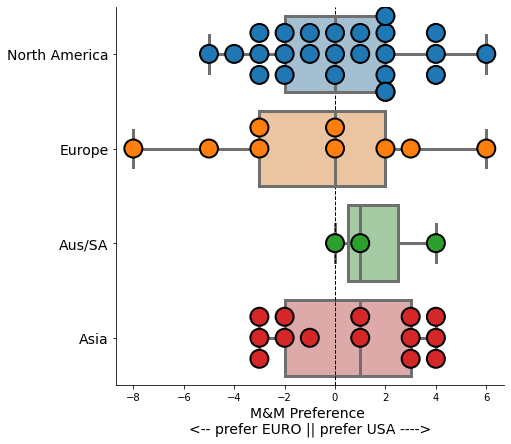

In [623]:
# swarm box overlay
g = sns.catplot(
    data=pdf_chop4, x='mnm_diff', y='continent_adj',
    kind='box',palette=lighter_tab10,
    boxprops=dict(alpha=1),height=6,aspect=7/6,linewidth=3,
)
g.map_dataframe(sns.swarmplot, x='mnm_diff', y='continent_adj',
                size=18, #alpha=0.99,
                edgecolor='black',linewidth=2, dodge=True,
                palette='tab10',
               )

plt.axvline(0,color='black',linestyle='--',linewidth=1)
plt.xlabel("M&M Preference \n<-- prefer EURO || prefer USA ---->",fontsize=14)
plt.ylabel("")
plt.yticks(fontsize=14)
g.savefig('figs/mnm_pref_box_swarm_diff_chop4.jpg',dpi=200)
plt.show()

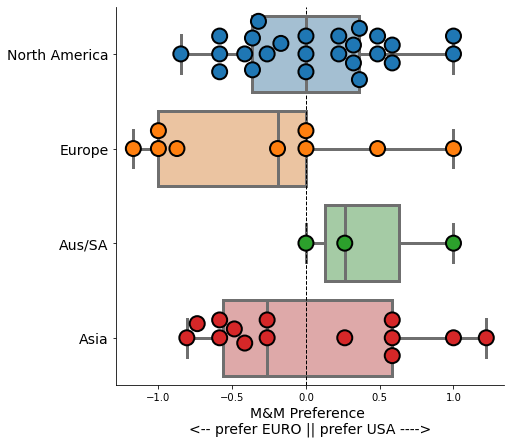

In [624]:
# swarm box overlay
g = sns.catplot(
    data=pdf_chop4, x='mnm_ratio', y='continent_adj',
    kind='box',palette=lighter_tab10,
    boxprops=dict(alpha=1),height=6,aspect=7/6,linewidth=3,
)
g.map_dataframe(sns.swarmplot, x='mnm_ratio', y='continent_adj',
                size=15, #alpha=0.99,
                edgecolor='black',linewidth=2, dodge=True,
                palette='tab10',
               )

plt.axvline(0,color='black',linestyle='--',linewidth=1)
plt.xlabel("M&M Preference \n<-- prefer EURO || prefer USA ---->",fontsize=14)
plt.ylabel("")
plt.yticks(fontsize=14)
g.savefig('figs/mnm_pref_box_swarm_ratio_chop4.jpg',dpi=200)
plt.show()

#### Other chart variants - not used

In [168]:
# alt.Chart(df).mark_bar(size=25).encode(
#     x=alt.X('taste_response:N',title="M&M Origin",sort=taste_order,
#             axis=alt.Axis(labelAngle=0,labelFontSize=10)),
#     y=alt.Y('count(mnm_origin)',title=""),
#     color=alt.Color('mnm_origin:N',title="origin"),
#     column=alt.Column('continent_adj:N',title='Continent',header=alt.Header(labelFontSize=10)),
# ).properties(width=105,height=75)

In [169]:
# alt.Chart(df).mark_bar().encode(
#     alt.Y("count(taste_response):N"),#stack=False),
#     alt.X("taste_response",sort=taste_order),
#     alt.Color("mnm_origin:N"),
#     alt.Column("continent_adj:N"),
#     alt.Row('mnm_origin')
# ).properties(height=100)

In [27]:
# alt.Chart(table2).mark_bar().encode(
#     alt.Y("percentage:Q"),#stack=False),
#     alt.X("taste_response",sort=order),
#     alt.Color("mnm_origin:N"),
#     alt.Column("continent:N"),
#     alt.Row('mnm_origin')
# ).properties(height=100)

In [28]:
# alt.Chart(df).mark_bar(size=25).encode(
#     alt.Y("count(taste_response):N",title="Count"),
#     alt.X("mnm_origin",sort=order,),
#     alt.Color("mnm_origin:N"),
#     alt.Column("taste_response:N",sort=order,spacing=1,header=alt.Header(labelFontSize=14)),
#     alt.Row('continent_adj',title='',sort='descending')
# ).properties(
#     width=60,
#     height=50,
# ).configure_axis(
#     grid=False,
# ).configure_view(
#     strokeOpacity=0.4
# )